In [1]:
import os
import numpy as np

import tensorflow as tf
from tensorflow import keras

print(tf.__version__, np.__version__)

# Expected output 2.9.0, 1.26.4

2.9.0 1.26.4


## Detect GPU and limit GPU memory usage if exist

In [2]:
USE_GPU = True

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')

if gpus != []:
    print(gpus)
    for gpu in gpus: 
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("No GPU on this machine")

# Expected output [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [4]:
if USE_GPU == False:
    os.environ['CUDA_VISIBLE_DEVICES'] = '-1'

In [5]:
if tf.test.gpu_device_name():
    print('GPU found')
else:
    print("No GPU found")

GPU found


# Model selector

In [6]:
INPUT_SHAPE = (224,224,3)
base_model = tf.keras.applications.RegNetX320(input_shape=INPUT_SHAPE, include_top=False, weights='imagenet')
model_name = "RegNetX320"

422542312/422542312 [==============================] - 22s 0us/step


# Load data

In [7]:
import numpy as np
from matplotlib import pyplot as plt

data_dir = r"C:\Users\kanan\Desktop\data_x\data_x\train"
data = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224, 224))

# Expected output Found 39703 files belonging to 2 classes.

Found 39703 files belonging to 2 classes.


In [8]:
data_iterator = data.as_numpy_iterator()
batch = data_iterator.next()

# Split Train/Val

In [9]:
train_size = int(len(data)*.8)
val_size = int(len(data)*.2)

In [10]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)

# Build model

In [11]:
# True = Training the base model

TRAIN_FULL_NETWROK = False

In [12]:
IMG_DIM = (224,224)

In [13]:
base_model.trainable = TRAIN_FULL_NETWROK

In [14]:
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

In [15]:
inputs = tf.keras.Input(shape=INPUT_SHAPE)

x = base_model(inputs, training=TRAIN_FULL_NETWROK)
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)

# A Dense classifier with a single unit (binary classification)
outputs = Dense(1, activation='sigmoid')(x)
model = Model(inputs=inputs, outputs=outputs)

In [16]:
import pandas as pd

pd.set_option('max_colwidth', None)
layers = [(layer, layer.name, layer.trainable) for layer in model.layers]
pd.DataFrame(layers, columns=['Layer Type', 'Layer Name', 'Layer Trainable'])

,Layer Type,Layer Name,Layer Trainable
0,<keras.engine.input_layer.InputLayer object at 0x000001570A7F7820>,input_2,True
1,<keras.engine.functional.Functional object at 0x000001564AFC70D0>,regnetx320,False
2,<keras.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D object at 0x000001570A8D81C0>,global_average_pooling2d,True
3,<keras.layers.core.dense.Dense object at 0x000001570A7F7EB0>,dense,True
4,<keras.layers.core.dense.Dense object at 0x0000015640B186A0>,dense_1,True
5,<keras.layers.core.dense.Dense object at 0x000001570AB93F10>,dense_2,True


In [17]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 regnetx320 (Functional)     (None, 7, 7, 2520)        105452576 
                                                                 
 global_average_pooling2d (G  (None, 2520)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 1024)              2581504   
                                                                 
 dense_1 (Dense)             (None, 512)               524800    
                                                                 
 dense_2 (Dense)             (None, 1)                 513       
                                                             

In [18]:
model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), # change from_logits=True
              optimizer= keras.optimizers.Adam(learning_rate=1e-2),
              metrics = [keras.metrics.BinaryAccuracy()])

# Set up training metrics

In [19]:
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger

In [20]:
dir_path = r"C:\Users\kanan\Desktop\data_x"

results_dir = "logs\\" + model_name
results_dir = os.path.join(dir_path, results_dir)

models_dir = "models\\" + model_name
models_dir = os.path.join(dir_path, models_dir)

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
    
if not os.path.isdir(models_dir):
    os.makedirs(models_dir)

In [21]:
log_file = os.path.join(results_dir, f"{model_name}_bo20_lr001.csv")

In [22]:
callbacks = [
    CSVLogger(log_file),
    ModelCheckpoint(
        filepath=os.path.join(models_dir, f"{model_name}_bo20_lr001.h5"),
        save_weights_only=False,
        save_best_only=True,
        save_freq='epoch',
        verbose=1
    )
]

# Train model

In [23]:
history = model.fit(train, 
                    validation_data=val,
                    epochs=20, 
                    verbose=1, 
                    callbacks=callbacks)

Epoch 1/20
992/992 [==============================] - ETA: 0s - loss: 0.6409 - binary_accuracy: 0.7287
Epoch 1: val_loss improved from inf to 0.47518, saving model to C:\Users\kanan\Desktop\data_x\models\RegNetX320\RegNetX320_bo20_lr001.h5
992/992 [==============================] - 931s 923ms/step - loss: 0.6409 - binary_accuracy: 0.7287 - val_loss: 0.4752 - val_binary_accuracy: 0.7776
Epoch 2/20
992/992 [==============================] - ETA: 0s - loss: 0.4746 - binary_accuracy: 0.7794
Epoch 2: val_loss improved from 0.47518 to 0.45361, saving model to C:\Users\kanan\Desktop\data_x\models\RegNetX320\RegNetX320_bo20_lr001.h5
992/992 [==============================] - 951s 959ms/step - loss: 0.4746 - binary_accuracy: 0.7794 - val_loss: 0.4536 - val_binary_accuracy: 0.8009
Epoch 3/20
992/992 [==============================] - ETA: 0s - loss: 0.4419 - binary_accuracy: 0.7967
Epoch 3: val_loss improved from 0.45361 to 0.41717, saving model to C:\Users\kanan\Desktop\data_x\models\RegNetX320

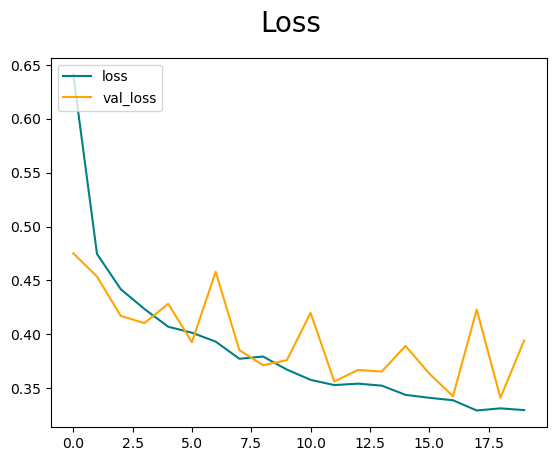

In [24]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Reducing learning rate from 0.01 to 0.001 and continue

Load model

In [25]:
from tensorflow.keras.models import load_model


saved_model_path = os.path.join(models_dir, f"{model_name}_bo20_lr001.h5")
new_model = load_model(saved_model_path)

Set new learning rate

In [26]:
current_optimizer = new_model.optimizer
current_lr = current_optimizer.learning_rate.numpy()

print(f"Old learning rate: {current_lr}")

Old learning rate: 0.009999999776482582


In [27]:
new_model.compile(loss=keras.losses.BinaryCrossentropy(from_logits=False), 
              optimizer= keras.optimizers.Adam(learning_rate=1e-3),
              metrics = [keras.metrics.BinaryAccuracy()])

In [28]:
current_optimizer = new_model.optimizer
current_lr = current_optimizer.learning_rate.numpy()

print(f"New learning rate: {current_lr}")

New learning rate: 0.0010000000474974513


Continue training

In [29]:
log_file = os.path.join(results_dir, f"{model_name}_bo20_lr0001.csv")

In [30]:
callbacks = [
    CSVLogger(log_file),
    ModelCheckpoint(
        filepath=os.path.join(models_dir,f"{model_name}_bo20_lr0001.h5"),
        save_weights_only=False,
        save_best_only=True,
        save_freq='epoch',
        verbose=1
    )
]

In [31]:
history = new_model.fit(train, 
                    validation_data=val,
                    epochs=20, 
                    verbose=1, 
                    callbacks=callbacks)

Epoch 1/20
992/992 [==============================] - ETA: 0s - loss: 0.2879 - binary_accuracy: 0.8731
Epoch 1: val_loss improved from inf to 0.33459, saving model to C:\Users\kanan\Desktop\data_x\models\RegNetX320\RegNetX320_bo20_lr0001.h5
992/992 [==============================] - 938s 942ms/step - loss: 0.2879 - binary_accuracy: 0.8731 - val_loss: 0.3346 - val_binary_accuracy: 0.8556
Epoch 2/20
992/992 [==============================] - ETA: 0s - loss: 0.2833 - binary_accuracy: 0.8748
Epoch 2: val_loss improved from 0.33459 to 0.33295, saving model to C:\Users\kanan\Desktop\data_x\models\RegNetX320\RegNetX320_bo20_lr0001.h5
992/992 [==============================] - 934s 941ms/step - loss: 0.2833 - binary_accuracy: 0.8748 - val_loss: 0.3330 - val_binary_accuracy: 0.8547
Epoch 3/20
992/992 [==============================] - ETA: 0s - loss: 0.2815 - binary_accuracy: 0.8754
Epoch 3: val_loss did not improve from 0.33295
992/992 [==============================] - 934s 942ms/step - loss:

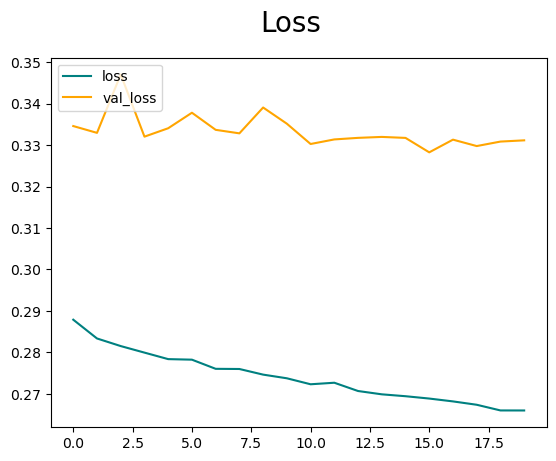

In [32]:
fig = plt.figure()
plt.plot(history.history['loss'], color='teal', label='loss')
plt.plot(history.history['val_loss'], color='orange', label='val_loss')
fig.suptitle('Loss', fontsize=20)
plt.legend(loc="upper left")
plt.show()

# Test

Load model

In [33]:
from tensorflow.keras.models import load_model

saved_model_path = os.path.join(models_dir, f"{model_name}_bo20_lr0001.h5")
test_model = load_model(saved_model_path)

Set measurement metrics

In [34]:
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy

pre = Precision()
re = Recall()
acc = BinaryAccuracy()

Load data

In [35]:
import numpy as np
from matplotlib import pyplot as plt

data_dir = r"C:\Users\kanan\Desktop\data_x\data_x\test"
test = tf.keras.utils.image_dataset_from_directory(data_dir, image_size=(224, 224))

# Expected output Found 7360 files belonging to 2 classes.

Found 7360 files belonging to 2 classes.


Testing

In [36]:
test_iterator = test.as_numpy_iterator()
batch = test_iterator.next()

In [37]:
for batch in test_iterator: 
    X, y = batch
    yhat = test_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)

1/1 [==============================] - 0s 28ms/step


ResourceExhaustedError: Graph execution error:

Detected at node 'model/regnetx320/regnetx320_Stage_0_XBlock_0_conv_3x3/StatefulPartitionedCall' defined at (most recent call last):
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\runpy.py", line 196, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\runpy.py", line 86, in _run_code
      exec(code, run_globals)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\ipykernel_launcher.py", line 18, in <module>
      app.launch_new_instance()
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\traitlets\config\application.py", line 1075, in launch_instance
      app.start()
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\ipykernel\kernelapp.py", line 739, in start
      self.io_loop.start()
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\tornado\platform\asyncio.py", line 205, in start
      self.asyncio_loop.run_forever()
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\asyncio\base_events.py", line 603, in run_forever
      self._run_once()
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\asyncio\base_events.py", line 1909, in _run_once
      handle._run()
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\ipykernel\kernelbase.py", line 545, in dispatch_queue
      await self.process_one()
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\ipykernel\kernelbase.py", line 534, in process_one
      await dispatch(*args)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\ipykernel\kernelbase.py", line 437, in dispatch_shell
      await result
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\ipykernel\ipkernel.py", line 362, in execute_request
      await super().execute_request(stream, ident, parent)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\ipykernel\kernelbase.py", line 778, in execute_request
      reply_content = await reply_content
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\ipykernel\ipkernel.py", line 449, in do_execute
      res = shell.run_cell(
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\ipykernel\zmqshell.py", line 549, in run_cell
      return super().run_cell(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3075, in run_cell
      result = self._run_cell(
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3130, in _run_cell
      result = runner(coro)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\IPython\core\async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3334, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3517, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\IPython\core\interactiveshell.py", line 3577, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\kanan\AppData\Local\Temp\ipykernel_14080\4016680956.py", line 3, in <module>
      yhat = test_model.predict(X)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\training.py", line 2033, in predict
      tmp_batch_outputs = self.predict_function(iterator)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\training.py", line 1845, in predict_function
      return step_function(self, iterator)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\training.py", line 1834, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\training.py", line 1823, in run_step
      outputs = model.predict_step(data)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\training.py", line 1791, in predict_step
      return self(x, training=False)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\training.py", line 490, in __call__
      return super().__call__(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\functional.py", line 458, in call
      return self._run_internal_graph(
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\functional.py", line 596, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\utils\traceback_utils.py", line 64, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\engine\base_layer.py", line 1014, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\utils\traceback_utils.py", line 92, in error_handler
      return fn(*args, **kwargs)
    File "c:\Users\kanan\miniconda3\envs\2dmodelGPU\lib\site-packages\keras\layers\convolutional\base_conv.py", line 248, in call
      outputs = self._jit_compiled_convolution_op(inputs, self.kernel)
Node: 'model/regnetx320/regnetx320_Stage_0_XBlock_0_conv_3x3/StatefulPartitionedCall'
Out of memory while trying to allocate 686074496 bytes.
BufferAssignment OOM Debugging.
BufferAssignment stats:
             parameter allocation:  516.44MiB
              constant allocation:         0B
        maybe_live_out allocation:  128.62MiB
     preallocated temp allocation:  654.29MiB
  preallocated temp fragmentation:         0B (0.00%)
                 total allocation:    1.27GiB
              total fragmentation:  126.65MiB (9.75%)
Peak buffers:
	Buffer 1:
		Size: 523.73MiB
		XLA Label: fusion
		Shape: f32[32,113,113,336]
		==========================

	Buffer 2:
		Size: 514.50MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[32,112,112,336]
		==========================

	Buffer 3:
		Size: 128.62MiB
		Operator: op_type="Conv2D" op_name="Conv2D" source_file="c:\\Users\\kanan\\miniconda3\\envs\\2dmodelGPU\\lib\\site-packages\\keras\\layers\\convolutional\\base_conv.py" source_line=225
		XLA Label: custom-call
		Shape: f32[32,56,56,336]
		==========================

	Buffer 4:
		Size: 128.62MiB
		Operator: op_type="Conv2D" op_name="Conv2D" source_file="c:\\Users\\kanan\\miniconda3\\envs\\2dmodelGPU\\lib\\site-packages\\keras\\layers\\convolutional\\base_conv.py" source_line=225
		XLA Label: copy
		Shape: f32[32,56,56,336]
		==========================

	Buffer 5:
		Size: 1.94MiB
		Operator: op_name="XLA_Args"
		XLA Label: copy
		Shape: f32[3,3,168,336]
		==========================

	Buffer 6:
		Size: 1.94MiB
		Operator: op_name="XLA_Args"
		Entry Parameter Subshape: f32[3,3,168,336]
		==========================

	Buffer 7:
		Size: 16B
		Operator: op_type="Conv2D" op_name="Conv2D" source_file="c:\\Users\\kanan\\miniconda3\\envs\\2dmodelGPU\\lib\\site-packages\\keras\\layers\\convolutional\\base_conv.py" source_line=225
		XLA Label: custom-call
		Shape: (f32[32,56,56,336], u8[2070016])
		==========================


	 [[{{node model/regnetx320/regnetx320_Stage_0_XBlock_0_conv_3x3/StatefulPartitionedCall}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info. This isn't available when running in Eager mode.
 [Op:__inference_predict_function_247548]

Test results

In [ ]:
f1_score = 2 * (pre.result() * re.result()) / (pre.result() + re.result())
print(f"Precision : {pre.result().numpy()}")
print(f"Recall : {re.result().numpy()}")
print(f"Accuracy : {acc.result().numpy()}")
print(f"F1 Score : {f1_score.numpy()}")